In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sn
import random
import datetime as dt
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from patsy import dmatrices
import statsmodels.api as sm

In [2]:
trip = pd.read_csv(r'C:\Users\Joyce Huang\Downloads\DBA5104 - Introduction to Network Science & Analytics\mini-project\trip.csv',parse_dates=['starttime','stoptime'], error_bad_lines=False)
station = pd.read_csv(r'C:\Users\Joyce Huang\Downloads\DBA5104 - Introduction to Network Science & Analytics\mini-project\station.csv', error_bad_lines=False)
weather = pd.read_csv(r'C:\Users\Joyce Huang\Downloads\DBA5104 - Introduction to Network Science & Analytics\mini-project\weather.csv', parse_dates=['Date'], error_bad_lines=False)
#display(trip)
#display(station)
#display(weather)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
trip['month'] = trip['starttime'].dt.strftime('%Y-%m')
trip['quarter'] = trip['starttime'].dt.to_period('Q')
trip

trip_monthly = trip.groupby(['month']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
nbr_of_trips = trip_monthly
#display(nbr_of_trips)

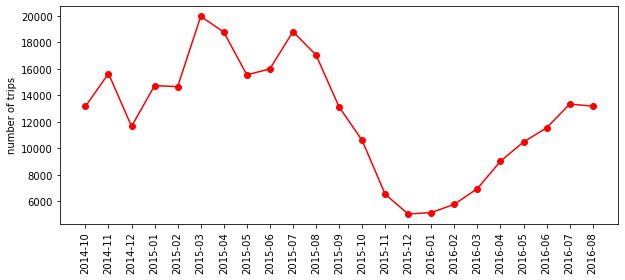

In [4]:
plt.figure(figsize=(10,4))
plt.plot(trip_monthly['month'],trip_monthly['nbr_of_trips'], color='red', marker='o')
plt.xticks(rotation='vertical')
plt.ylabel('number of trips')
plt.show()

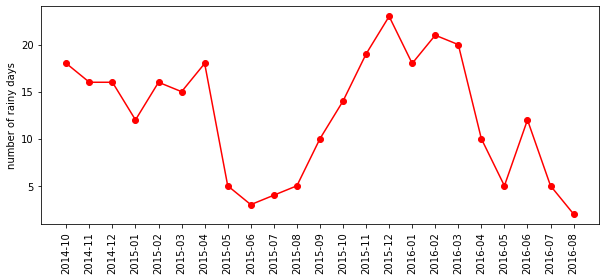

In [5]:
weather['month'] = weather['Date'].dt.strftime('%Y-%m')
rainy_weather = weather[weather['Events']=='Rain']
rainy_weather_count = rainy_weather[['month','Events']].groupby(['month']).count().reset_index()
#display(rainy_weather_count)

plt.figure(figsize=(10,4))
plt.plot(rainy_weather_count['month'],rainy_weather_count['Events'], color='red', marker='o')
plt.xticks(rotation='vertical')
plt.ylabel('number of rainy days')
plt.show()

In [6]:
# Grouping the trips by usertype
trip_usertype = trip.groupby(['month','usertype']).agg(
    nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

member_count = pd.pivot(trip_usertype, values='nbr_of_trips', index='month',columns='usertype').reset_index()
#display(member_count)

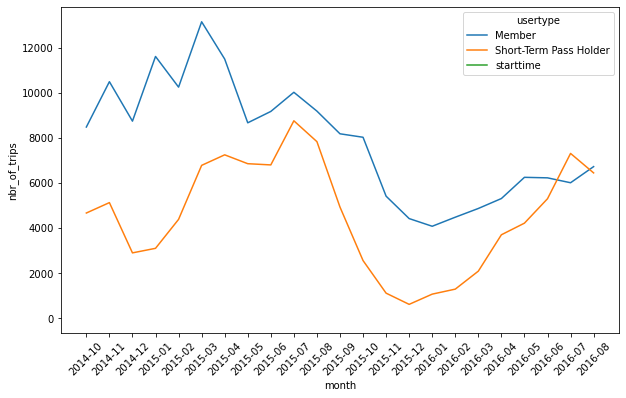

In [7]:
plt.figure(figsize=(10,6))
sn.lineplot(x='month', y='nbr_of_trips', hue='usertype', data=trip_usertype)
plt.xticks(rotation=45)
plt.show()

In [8]:
# Grouping the trips data by gender
trip_gender = trip.groupby(['month','gender']).agg(
    nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()

gender_count = pd.pivot(trip_gender, values='nbr_of_trips', index='month',columns='gender').reset_index()
#display(gender_count)

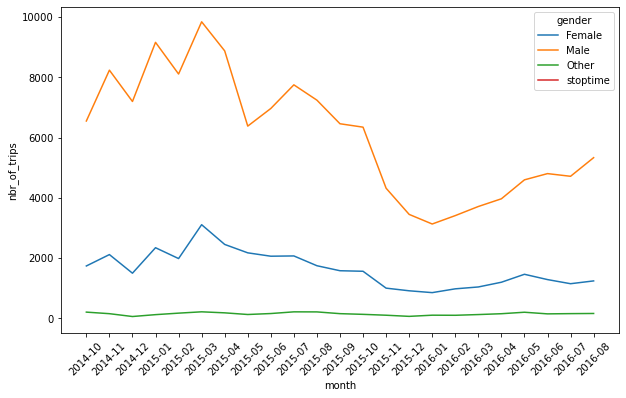

In [9]:
plt.figure(figsize=(10,6))
sn.lineplot(x='month', y='nbr_of_trips', hue='gender', data=trip_gender)
plt.xticks(rotation=45)
plt.show()

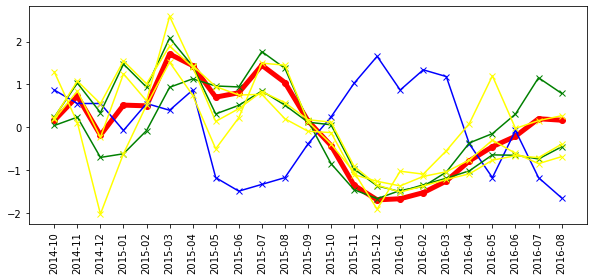

In [63]:
frames = [nbr_of_trips, rainy_weather_count, member_count, gender_count]
df = pd.concat(frames, axis=1)
c = ['month','nbr_of_trips', 'Events','Member','Short-Term Pass Holder','Female','Male','Other']
df = df[c]
df.columns = ['month','month_2','month_3','month_4','nbr_of_trips', 'Events','Member','Short-Term-Pass-Holder','Female','Male','Other']
c = ['month','nbr_of_trips', 'Events','Member','Short-Term-Pass-Holder','Female','Male','Other']
df = df[c]
#display(df)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df2 = scaler.fit_transform(df.iloc[:,1:8])
df2 = pd.DataFrame(df2)
df2.columns=['nbr_of_trips', 'Events','Member','Short-Term-Pass-Holder','Female','Male','Other']
df2['month'] = df['month']
#display(df2)

plt.figure(figsize=(10,4))
plt.plot(df2['month'],df2['nbr_of_trips'], color='red', marker='o', lw=5)
plt.plot(df2['month'],df2['Events'], color='blue', marker='x')
plt.plot(df2['month'],df2['Member'], color='green', marker='x')
plt.plot(df2['month'],df2['Short-Term-Pass-Holder'], color='green', marker='x')
plt.plot(df2['month'],df2['Female'], color='yellow', marker='x')
plt.plot(df2['month'],df2['Male'], color='yellow', marker='x')
plt.plot(df2['month'],df2['Other'], color='yellow', marker='x')
plt.xticks(rotation='vertical')
plt.show()

##### As we can see numbers of trips is positively correlated with:
1. member / short-term pass holder
2. female / male / other

##### and negatively correlated with:
the number of weather events, such as rainning

### Network Analysis
grouping by station A, station B

In [11]:
df3 = trip.groupby(['Source','Target']).agg(nbr_of_trips = pd.NamedAgg(column = 'trip_id',aggfunc = 'count')).reset_index()
df3
df3=df3.iloc[1:,:]

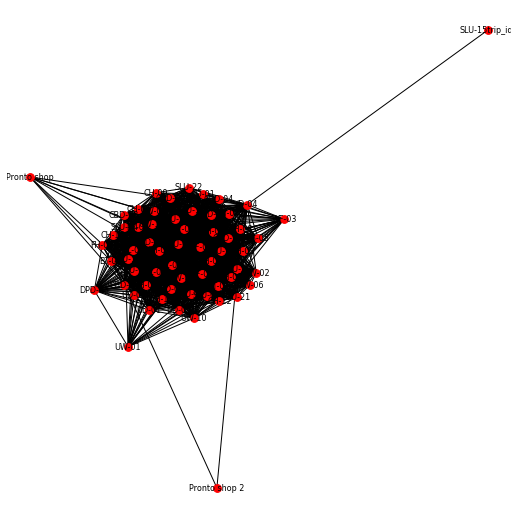

In [12]:
# Network
G = nx.from_pandas_edgelist(df3, 'Source', 'Target','nbr_of_trips')
#print(G.edges(data=True))
plt.figure(3,figsize=(7,7)) 
nx.draw(G, with_labels=True, node_color='red',node_size=60,font_size=8)
plt.show()

### Study of Network Resilience

In [13]:
df3.to_csv(r'C:\Users\Joyce Huang\Downloads\DBA5104 - Introduction to Network Science & Analytics\mini-project\df3.csv')

##### list-wise removal of nodes

In [14]:
print(df3.shape)
# import random
# l = [i for i in range(2943)]
# l2 = random.choices(l, k=100)
avg_path_len = []
cluster = []

e = G.nodes
l3 = list(e.keys())
#print(l3)
l3.remove('SLU-15trip_id"')
#print(l3)
print(len(l3))

for i in l3:
    G.remove_node(i)
    
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    subgraph = G.subgraph(largest_component)
    diameter = nx.diameter(subgraph)
    avg_path = nx.average_shortest_path_length(subgraph)
    
    avg_path_len.append(avg_path)
    
    global_cluster = nx.average_clustering(G)
    
    cluster.append(global_cluster)
    
#print(avg_path_len)
#print(cluster)

(2943, 3)
60


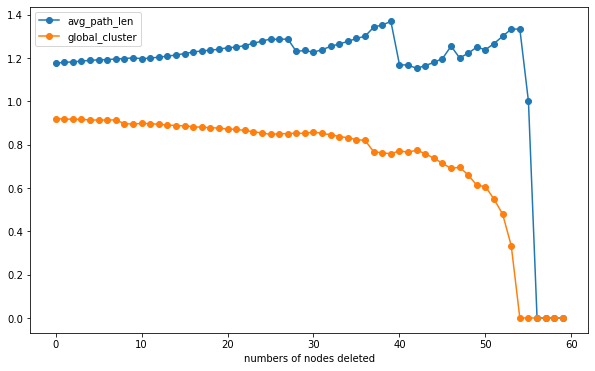

In [15]:
df5 = pd.DataFrame(avg_path_len)  
df5['global_cluster'] = cluster
df5.columns = ['avg_path_len','global_cluster']
df5

x = np.arange(0,60)
y = df5['avg_path_len']
y2 = df5['global_cluster']

plt.figure(figsize=(10,6))
plt.plot(x,y,marker='o',label='avg_path_len')
plt.plot(x,y2,marker='o',label='global_cluster')
plt.legend(loc='best')
plt.xlabel('numbers of nodes deleted')

plt.show()

##### Attack network sequentially with the most connected node

In [16]:
df6 = pd.read_csv(r'C:\Users\Joyce Huang\Downloads\DBA5104 - Introduction to Network Science & Analytics\mini-project\df3.csv')
display(df6)

G = nx.from_pandas_edgelist(df6, 'Source', 'Target','nbr_of_trips')

#Degree
degree = nx.degree(G)
degree = dict((x, y) for x, y in degree)
#print(degree)

# Closeness
closeness = nx.closeness_centrality(G)
#print(closeness)

# Clustering coefficient
cluster_co = nx.clustering(G)
#print(cluster_co)

# Page Rank
pagerank = nx.pagerank(G)
#print(pagerank)

# Eccentricity
eccen = nx.eccentricity(G)
#print(eccen)

list = [degree, closeness, cluster_co, pagerank, eccen]
df7 = pd.DataFrame(list)
df7 = df7.T
df7.columns = ['degree','closeness', 'cluster', 'pagerank', 'eccentricity']
df7 = df7.sort_values(by=['degree', 'cluster', 'pagerank', 'eccentricity'], ascending=False)
df7

,Unnamed: 0,Source,Target,nbr_of_trips
0,1,BT-01,BT-01,738
1,2,BT-01,BT-03,221
2,3,BT-01,BT-04,137
3,4,BT-01,BT-05,470
4,5,BT-01,CBD-03,228
...,...,...,...,...
2938,2939,WF-04,UW-10,2
2939,2940,WF-04,UW-11,5
2940,2941,WF-04,WF-01,1930
2941,2942,WF-04,WF-03,17


,degree,closeness,cluster,pagerank,eccentricity
SLU-17,60.0,0.967742,0.885662,0.018702,2.0
EL-01,59.0,0.952381,0.912281,0.018237,2.0
EL-03,59.0,0.952381,0.912281,0.018237,2.0
SLU-01,59.0,0.952381,0.912281,0.018237,2.0
CH-07,59.0,0.952381,0.899749,0.018401,2.0
...,...,...,...,...,...
WF-03,31.0,0.659341,0.997537,0.010624,2.0
UW-01,27.0,0.618557,0.986667,0.009513,3.0
Pronto shop,9.0,0.535714,1.000000,0.004923,3.0
Pronto shop 2,4.0,0.487805,1.000000,0.004233,3.0


In [17]:
df7.reset_index(inplace=True)
sorted = df7['index'].tolist()
print(type(sorted))

<class 'list'>


In [18]:
print(sorted)
sorted.remove('SLU-15trip_id"')

['SLU-17', 'EL-01', 'EL-03', 'SLU-01', 'CH-07', 'SLU-02', 'CH-06', 'SLU-15', 'CH-02', 'CH-15', 'DPD-01', 'EL-05', 'SLU-04', 'UD-04', 'BT-01', 'SLU-07', 'CH-05', 'CBD-03', 'CH-03', 'CH-08', 'CBD-13', 'WF-01', 'SLU-16', 'BT-03', 'WF-04', 'SLU-19', 'UD-02', 'UD-07', 'BT-05', 'SLU-20', 'CH-12', 'BT-04', 'PS-04', 'SLU-18', 'CBD-06', 'CH-01', 'CH-09', 'CBD-04', 'ID-04', 'CH-16', 'FH-04', 'UW-04', 'CBD-07', 'SLU-21', 'CBD-05', 'UW-07', 'SLU-22', 'UD-01', 'PS-05', 'UW-10', 'FH-01', 'UW-02', 'CD-01', 'UW-06', 'UW-11', 'DPD-03', 'WF-03', 'UW-01', 'Pronto shop', 'Pronto shop 2', 'SLU-15trip_id"']


In [19]:
sort_cluster = []
sort_path_len = []

for k in sorted:
    G.remove_node(k)
    
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    subgraph = G.subgraph(largest_component)
    diameter = nx.diameter(subgraph)
    avg_path = nx.average_shortest_path_length(subgraph)
    
    sort_path_len.append(avg_path)
    
    global_cluster = nx.average_clustering(G)
    
    sort_cluster.append(global_cluster)

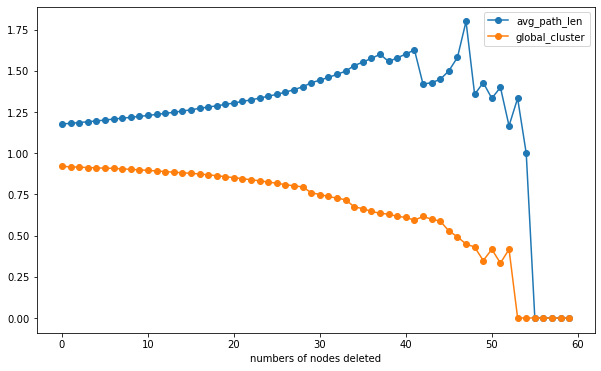

In [21]:
df8 = pd.DataFrame(sort_path_len)  
df8['global_cluster'] = sort_cluster
df8.columns = ['avg_path_len','global_cluster']

x = np.arange(0,60)
y = df8['avg_path_len']
y2 = df8['global_cluster']

plt.figure(figsize=(10,6))
plt.plot(x,y,marker='o',label='avg_path_len')
plt.plot(x,y2,marker='o',label='global_cluster')
plt.legend(loc='best')
plt.xlabel('numbers of nodes deleted')

plt.show()

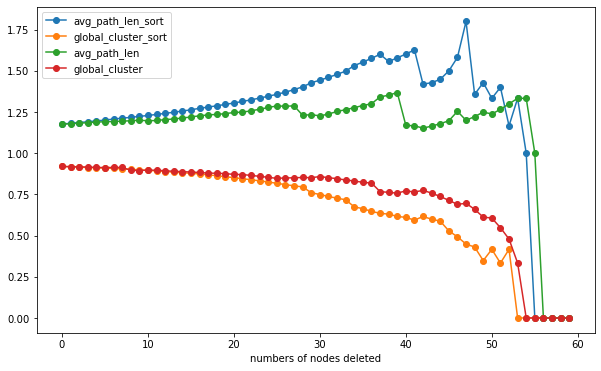

In [22]:
x = np.arange(0,60)
y = df8['avg_path_len']
y2 = df8['global_cluster']
y3 = df5['avg_path_len']
y4 = df5['global_cluster']

plt.figure(figsize=(10,6))
plt.plot(x,y,marker='o',label='avg_path_len_sort')
plt.plot(x,y2,marker='o',label='global_cluster_sort')
plt.plot(x,y3,marker='o',label='avg_path_len')
plt.plot(x,y4,marker='o',label='global_cluster')
plt.legend(loc='best')
plt.xlabel('numbers of nodes deleted')

plt.show()

##### Other analysis on the network

In [64]:
weather['month'] = weather['Date'].dt.strftime('%Y-%m')
mean_temperature = weather[['month','Mean_Temperature_F']].groupby(['month']).mean().reset_index()
mean_dew = weather[['month','MeanDew_Point_F']].groupby(['month']).mean().reset_index()
mean_humidity = weather[['month','Mean_Humidity']].groupby(['month']).mean().reset_index()
mean_pressure = weather[['month','Mean_Sea_Level_Pressure_In']].groupby(['month']).mean().reset_index()
mean_visibility = weather[['month','Mean_Visibility_Miles']].groupby(['month']).mean().reset_index()
mean_wind_speed = weather[['month','Mean_Wind_Speed_MPH']].groupby(['month']).mean().reset_index()
mean_precipitation = weather[['month','Precipitation_In']].groupby(['month']).mean().reset_index()

frames = [mean_temperature, mean_dew, mean_humidity, mean_pressure, mean_visibility, mean_wind_speed, mean_precipitation]
df9 = pd.concat(frames, axis=1)
df9.columns = ['month', 'Mean_Temperature_F', 
              'm_1', 'MeanDew_Point_F',
              'm_2', 'Mean_Humidity', 
              'm_3', 'Mean_Sea_Level_Pressure_In',
              'm_4', 'Mean_Visibility_Miles', 
              'm_5', 'Mean_Wind_Speed_MPH',
              'm_6', 'Precipitation_In']
c = ['month', 'Mean_Temperature_F', 
              'MeanDew_Point_F',
              'Mean_Humidity', 
              'Mean_Sea_Level_Pressure_In',
              'Mean_Visibility_Miles', 
              'Mean_Wind_Speed_MPH',
              'Precipitation_In']
df9 = df9[c]
#display(df9)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df10 = scaler.fit_transform(df9.iloc[:,1:8])
df10 = pd.DataFrame(df10)
df10.columns=['Mean_Temperature_F', 
              'MeanDew_Point_F',
              'Mean_Humidity', 
              'Mean_Sea_Level_Pressure_In',
              'Mean_Visibility_Miles', 
              'Mean_Wind_Speed_MPH',
              'Precipitation_In']
df10['month'] = df9['month']
df10['nbr_of_trips'] = df2['nbr_of_trips']
display(df10.head())

df13 = df2.drop('nbr_of_trips',axis=1)
df12 = pd.concat([df13,df11], axis=1)
#display(df12)


,Mean_Temperature_F,MeanDew_Point_F,Mean_Humidity,Mean_Sea_Level_Pressure_In,Mean_Visibility_Miles,Mean_Wind_Speed_MPH,Precipitation_In,month,nbr_of_trips
0,0.181666,0.874400,0.757280,-2.461723,-0.192964,1.015477,2.020407,2014-10,0.159495
1,-0.971737,-1.517915,-0.031390,0.637012,-0.220256,0.353345,0.348320,2014-11,0.725339
2,-1.069793,-1.343324,0.308432,-0.101174,-0.236983,-0.355527,0.385103,2014-12,-0.185130
3,-1.027314,-0.741616,1.225204,2.163402,-3.136311,-1.383261,-0.399221,2015-01,0.517375
4,-0.633117,-0.546777,0.475060,0.884971,-0.677059,-1.184208,0.575121,2015-02,0.500007


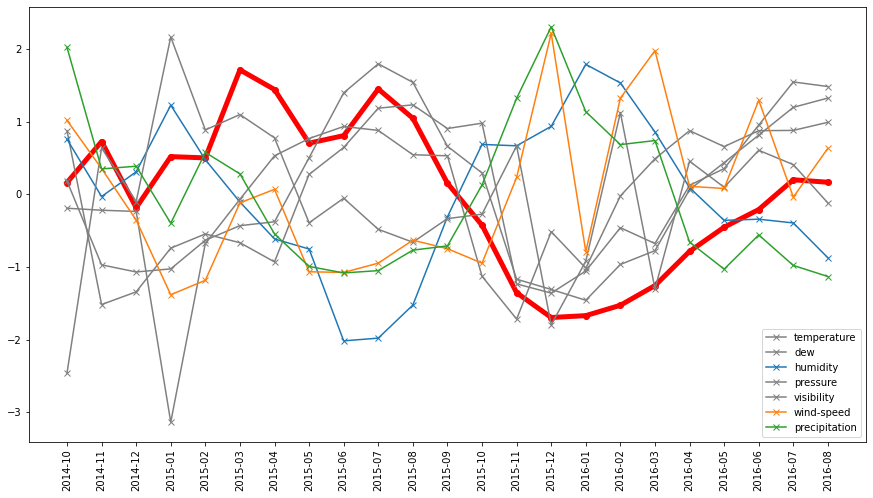

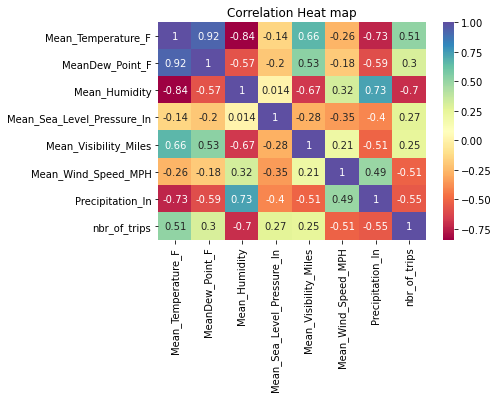

In [65]:
plt.figure(figsize=(15,8))
plt.plot(df10['month'],df10['nbr_of_trips'], color='red', marker='o', lw=5)
plt.plot(df10['month'],df10['Mean_Temperature_F'], marker='x', label='temperature',color='grey')
plt.plot(df10['month'],df10['MeanDew_Point_F'], marker='x',label='dew',color='grey')
plt.plot(df10['month'],df10['Mean_Humidity'], marker='x',label='humidity')
plt.plot(df10['month'],df10['Mean_Sea_Level_Pressure_In'], marker='x',label='pressure',color='grey')
plt.plot(df10['month'],df10['Mean_Visibility_Miles'], marker='x',label='visibility',color='grey')
plt.plot(df10['month'],df10['Mean_Wind_Speed_MPH'], marker='x',label='wind-speed')
plt.plot(df10['month'],df10['Precipitation_In'], marker='x',label='precipitation')
plt.legend(loc='best')
plt.xticks(rotation='vertical')
plt.show()

df11 = df10.drop('month',axis=1)
corr_matrix = df11.corr()
sn.heatmap(corr_matrix, annot=True, cmap='Spectral')
plt.title('Correlation Heat map')
plt.show()

Numbers of trips are more correlated with:
1. temperature
2. humidity
3. wind speed
4. precipitation

In [71]:
from statsmodels.formula.api import ols
display(df12.columns)
model = ols('nbr_of_trips ~ MeanDew_Point_F + Mean_Sea_Level_Pressure_In + Mean_Visibility_Miles + Events + Mean_Temperature_F + Mean_Humidity + Mean_Wind_Speed_MPH + Precipitation_In',df12).fit()
model.summary()

Index(['Events', 'Member', 'Short-Term-Pass-Holder', 'Female', 'Male', 'Other',
       'month', 'Mean_Temperature_F', 'MeanDew_Point_F', 'Mean_Humidity',
       'Mean_Sea_Level_Pressure_In', 'Mean_Visibility_Miles',
       'Mean_Wind_Speed_MPH', 'Precipitation_In', 'nbr_of_trips'],
      dtype='object')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nbr_of_trips   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     4.130
Date:                Fri, 04 Mar 2022   Prob (F-statistic):             0.0101
Time:                        14:10:47   Log-Likelihood:                -18.698
No. Observations:                  23   AIC:                             55.40
Df Residuals:                      14   BIC:                             65.62
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                  -1.769e-16      0.146  -1.21e-15      1.000      -0.313       0.313
MeanDew_Point_F                2.1527      2.144      1.004      0.332      -2.445       6.750
Mean_Sea_Level_Pressure_In     0.1977      0.266      0.744      0.469      -0.372       0.768
Mean_Visibility_Miles         -0.1191      0.313     -0.380      0.709      -0.790       0.552
Events                         0.5038      0.463      1.088      0.295      -0.489       1.497
Mean_Temperature_F            -3.0448      3.322     -0.917      0.375     -10.169       4.080
Mean_Humidity                 -2.3952      1.538     -1.557      0.142      -5.695       0.904
Mean_Wind_Speed_MPH           -0.3005      0.239     -1.257      0.229      -0.813       0.212
Precipitation_In              -0.0236      0.504     -0.047      0.963      -1.104       1.057
==============================================================================
Omnibus:                        1.659   Durbin-Watson:                   1.297
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                0.455
Skew:                          -0.074   Prob(JB):                        0.796
Kurtosis:                       3.673   Cond. No.                         62.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
G = nx.from_pandas_edgelist(trip, 'Source', 'Target', ['bikeid', 'usertype', 'gender', 'birthyear'])
G['CBD-06']['PS-04']['birthyear']
G['CBD-06']['PS-04']['gender']
G['CBD-06']['PS-04']['gender']

'Female'